In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
import torch.nn.functional as F

2.a MHIST

In [ ]:

# Define the path for the MHIST dataset
mh_dataset_path = '/content/drive/MyDrive/ECE1512/ProjectB/Project_B_Supp/mhist_dataset'

# Reading annotation data from the CSV file
annotations_file = "/content/drive/MyDrive/ECE1512/ProjectB/Project_B_Supp/mhist_dataset/annotations.csv"
annotations_data = pd.read_csv(annotations_file, delimiter=',')

# Separate data into training and testing based on 'Partition' column
training_data = annotations_data[annotations_data['Partition'] == 'train']
testing_data = annotations_data[annotations_data['Partition'] == 'test']

# Directory path for the image files
image_folder = "/content/drive/MyDrive/ECE1512/ProjectB/Project_B_Supp/mhist_dataset/images"

# Function for image loading and processing
def process_image(file_path):
    image = Image.open(file_path)
    image = image.resize((64, 64))  # Resize images to 64x64 pixels
    image_np = np.array(image) / 255.0  # Normalize the pixel values
    return image_np

# Gather image file paths and their corresponding labels
image_files = [os.path.join(image_folder, filename) for filename in annotations_data['Image Name']]
labels = annotations_data['Partition'].values

# Encoding labels
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Splitting dataset into training and testing
train_files, test_files, y_train, y_test = train_test_split(
    image_files, encoded_labels, test_size=0.2, random_state=42
)

# Processing images
train_images = np.array([process_image(path) for path in tqdm(train_files)])
test_images = np.array([process_image(path) for path in tqdm(test_files)])

# Model definition
class_count = len(np.unique(encoded_labels))  # Number of unique classes
mh_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(class_count, activation='softmax')
])

# Model compilation
mh_model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Model training
train_history = mh_model.fit(train_images, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Testing the model
evaluation_loss, evaluation_accuracy = mh_model.evaluate(test_images, y_test)
print(f'Test Accuracy: {evaluation_accuracy}')


100%|██████████| 631/631 [02:17<00:00,  4.57it/s]


Epoch 1/20
63/63 [==============================] - 23s 349ms/step - loss: 1.7682 - accuracy: 0.6870 - val_loss: 0.6336 - val_accuracy: 0.6851
Epoch 2/20
63/63 [==============================] - 20s 319ms/step - loss: 0.6190 - accuracy: 0.6959 - val_loss: 0.6280 - val_accuracy: 0.6851
Epoch 3/20
63/63 [==============================] - 20s 310ms/step - loss: 0.6260 - accuracy: 0.6959 - val_loss: 0.6230 - val_accuracy: 0.6851
Epoch 4/20
63/63 [==============================] - 19s 297ms/step - loss: 0.6163 - accuracy: 0.6959 - val_loss: 0.6242 - val_accuracy: 0.6851
Epoch 5/20
63/63 [==============================] - 19s 298ms/step - loss: 0.6165 - accuracy: 0.6959 - val_loss: 0.6237 - val_accuracy: 0.6851
Epoch 6/20
63/63 [==============================] - 19s 297ms/step - loss: 0.6150 - accuracy: 0.6959 - val_loss: 0.6230 - val_accuracy: 0.6851
Epoch 7/20
63/63 [==============================] - 19s 297ms/step - loss: 0.6149 - accuracy: 0.6959 - val_loss: 0.6252 - val_accuracy: 0.6851

2.a MNIST

In [ ]:
# Defining a Feedforward Neural Network
''' MLP '''
class MLP(nn.Module):
    def __init__(self, channel, num_classes):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28*28*1 if channel==1 else 32*32*3, 128)
        self.fc_2 = nn.Linear(128, 128)
        self.fc_3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)
        return out

# Preparing the MNIST dataset
dataset_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_training = datasets.MNIST(root='./data', train=True, download=True, transform=dataset_transform)
mnist_testing = datasets.MNIST(root='./data', train=False, download=True, transform=dataset_transform)

training_loader = DataLoader(mnist_training, batch_size=64, shuffle=True)
testing_loader = DataLoader(mnist_testing, batch_size=64, shuffle=False)

# Setting up the neural network
ff_network = MLP(input_channels=1, class_count=10)

# Loss function, optimizer, and learning rate scheduler
loss_function = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(ff_network.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = CosineAnnealingLR(sgd_optimizer, T_max=20, eta_min=0.001)

# Training procedure
def model_training(network, loader, loss_fn, optimizer):
    network.train()
    for _, (inputs, targets) in enumerate(loader):
        optimizer.zero_grad()
        predictions = network(inputs)
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

# Testing procedure
def model_testing(network, loader):
    network.eval()
    total_correct = 0
    cumulative_flops = 0
    with torch.no_grad():
        for inputs, targets in loader:
            predictions = network(inputs)
            _, preds = predictions.max(1)
            total_correct += preds.eq(targets).sum().item()

            # FLOPs Calculation
            flops = 2 * 128 * network.flatten_size
            cumulative_flops += flops

    test_accuracy = total_correct / len(loader.dataset)
    flops_per_second = cumulative_flops / len(loader.dataset)

    return test_accuracy, flops_per_second

# Running the training cycles
for epoch in range(20):
    model_training(ff_network, training_loader, loss_function, sgd_optimizer)
    lr_scheduler.step()

# Evaluating the network
accuracy, flops = model_testing(ff_network, testing_loader)
print("Accuracy of Model: {:.2f}%".format(accuracy * 100))
print("FLOPs per Second: {:.2f}".format(flops))


Accuracy of Model: 98.07%
FLOPs per Second: 3151.05


2.b MHIST

In [ ]:
# Setting up labels from CSV data
vote_label = 'Majority Vote Label'

# Splitting data based on partitioning
train_data = annotations_data[annotations_data['Partition'] == 'train']
test_data = annotations_data[annotations_data['Partition'] == 'test']

# Encoding labels for the training dataset
encoder = LabelEncoder()
encoded_train_labels = encoder.fit_transform(train_data[vote_label].values)

# Transforming test data labels consistently
encoded_test_labels = encoder.transform(test_data[vote_label].values)

# Preparing paths for image loading
path_images = [os.path.join(image_folder, image_name) for image_name in train_data['Image Name']]

# Filtering out unloadable images
valid_images = [process_image(path) for path in path_images]
valid_indexes = [index for index, img in enumerate(valid_images) if img is not None]

# Cleaning data and labels
valid_images = [img for img in valid_images if img is not None]
encoded_train_labels = encoded_train_labels[valid_indexes]

# Data partitioning into training and validation
train_imgs, val_imgs, y_train, y_val = train_test_split(
    valid_images, encoded_train_labels, test_size=0.2, random_state=42
)

# Defining classes and hyperparameters for the Gradient Matching algorithm
class_count = len(np.unique(y_train))
init_weights = 200
iteration_count = 10
lr_condensed = 0.1
opt_steps_condensed = 1
lr_model = 0.01
opt_steps_model = 50
class_batch = 128

# Building a convolutional neural network
cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(class_count, activation='softmax')
])

# Model compilation
cnn.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initialization for synthetic images
synth_images = np.random.normal(0, 1, (init_weights, 64, 64, 3))
synth_images_tensor = tf.constant(synth_images, dtype=tf.float32)

# Implementing the Gradient Matching algorithm
for cycle in tqdm(range(iteration_count)):
    # Updating the condensed samples
    for _ in range(opt_steps_condensed):
        with tf.GradientTape() as gtape:
            gtape.watch(synth_images_tensor)
            synthetic_loss = tf.reduce_sum(cnn(synth_images_tensor))
        synthetic_grads = gtape.gradient(synthetic_loss, synth_images_tensor)
        synth_images_tensor -= lr_condensed * synthetic_grads.numpy()

    synth_images = synth_images_tensor.numpy()

    # Model updating
    for _ in range(opt_steps_model):
        sample_indices = np.random.choice(len(train_imgs), class_batch, replace=False)
        batch_imgs = np.array(train_imgs)[sample_indices]
        batch_y = y_train[sample_indices]

        with tf.GradientTape() as mtape:
            model_predictions = cnn(batch_imgs)
            model_loss = tf.keras.losses.sparse_categorical_crossentropy(batch_y, model_predictions)

        model_grads = mtape.gradient(model_loss, cnn.trainable_variables)
        sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        sgd_optimizer.apply_gradients(zip(model_grads, cnn.trainable_variables))

# Cloning the model for evaluation
eval_cnn = models.clone_model(cnn)
eval_cnn.set_weights(cnn.get_weights())
eval_cnn.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prepare the test dataset for evaluation
test_image_paths = [os.path.join(image_folder, name) for name in test_data['Image Name']]
test_images = np.array([process_image(path) for path in test_image_paths])
test_labels = np.array(encoded_test_labels)

# Evaluate and print the accuracy
test_accuracy = eval_cnn.evaluate(test_images, test_labels, verbose=2)[1]
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


100%|██████████| 10/10 [12:12<00:00, 73.25s/it]


In [ ]:
# Prepare the test dataset for evaluation
test_image_paths = [os.path.join(image_folder, name) for name in test_data['Image Name']]
test_images = np.array([process_image(path) for path in test_image_paths])
test_labels = np.array(encoded_test_labels)

# Evaluate and print the accuracy
test_accuracy = eval_cnn.evaluate(test_images, test_labels, verbose=2)[1]
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

31/31 - 3s - loss: 0.6773 - accuracy: 1.0000 - 3s/epoch - 112ms/step
Test Accuracy: 100.00%


2.b MNIST

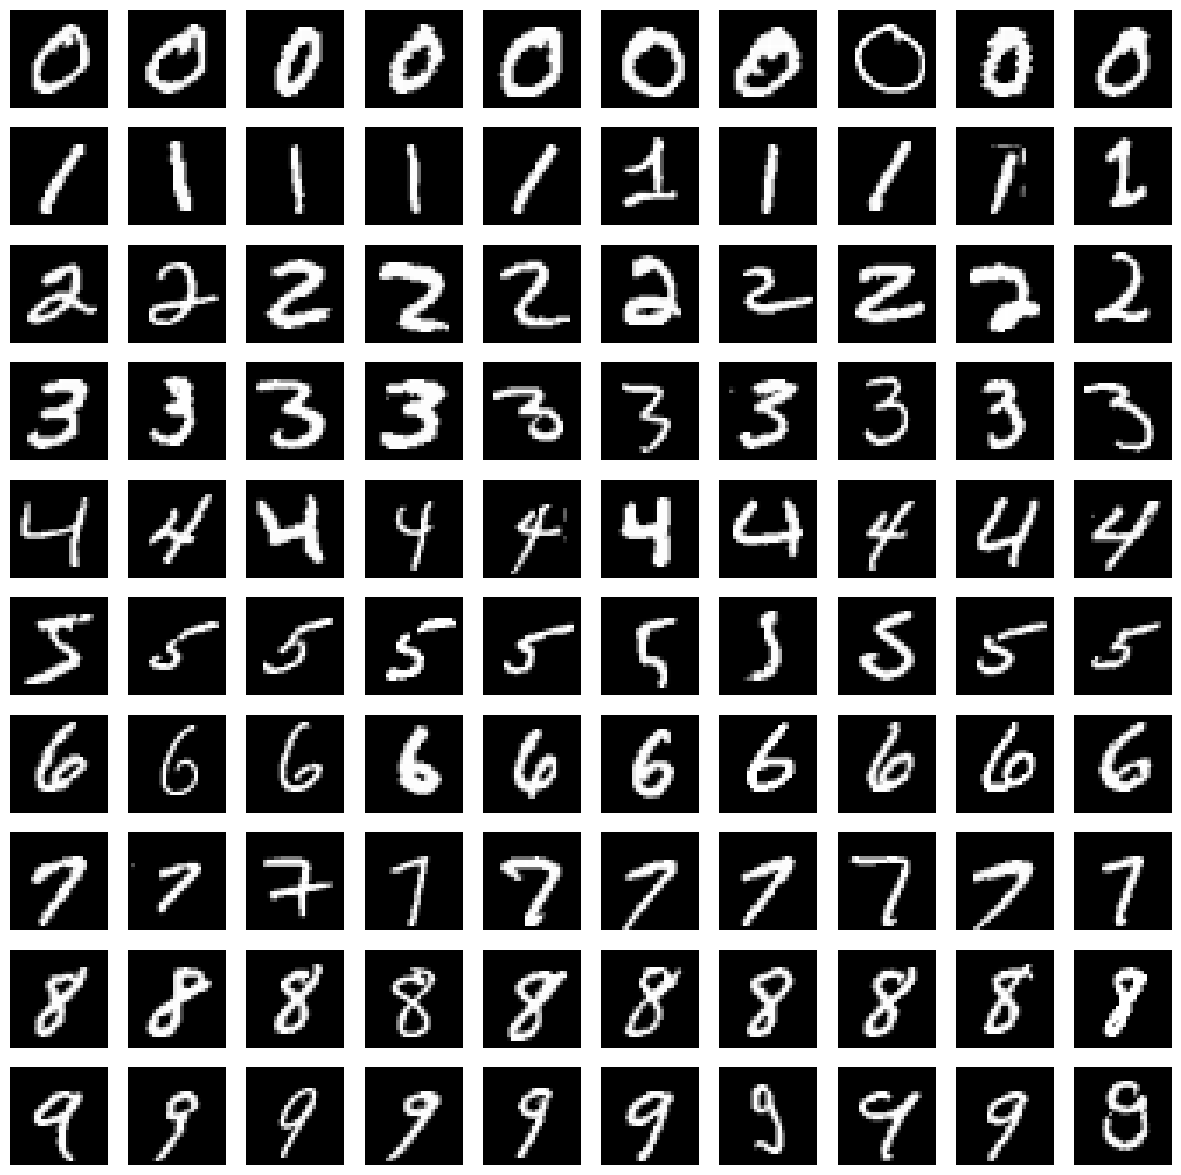

Test Accuracy: 0.25


In [ ]:
def gradient_matching_algorithm(model, dataset, lr_condensed=0.1, num_iterations=10, num_opt_steps=1):
    # Define optimizer for condensed samples
    optimizer_condensed = optim.SGD(model.parameters(), lr=lr_condensed)

    for iteration in range(num_iterations):
        # Randomly initialize weights
        model.apply(initialize_weights)

        # Train on the synthetic dataset
        for step in range(num_opt_steps):
            # Sample mini-batch from the synthetic dataset
            inputs, targets = sample_minibatch(dataset, minibatch_size=256)

            # Forward pass
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            # Backward pass and optimization
            optimizer_condensed.zero_grad()
            loss.backward()
            optimizer_condensed.step()

    return model

# Custom function for initializing model weights
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight)
        nn.init.zeros_(layer.bias)

# Function to create a condensed dataset
def create_condensed_dataset(original_dataset, images_per_class):
    selected_indices = []
    for class_id in original_dataset.targets.unique():
        class_indices = (original_dataset.targets == class_id).nonzero(as_tuple=True)[0][:images_per_class]
        selected_indices.extend(class_indices.tolist())
    return Subset(original_dataset, selected_indices)

# Custom MLP model with random weight initialization
class CustomMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train the model
def train_custom_model(custom_model, data_loader, learning_rate=0.01, epochs=10):
    optimizer = optim.SGD(custom_model.parameters(), lr=learning_rate)
    custom_model.apply(initialize_weights)

    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            outputs = custom_model(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()

# Data transformation
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='./data', train=True, transform=data_transform, download=True)

# Condensing the dataset
condensed_mnist_train = create_condensed_dataset(mnist_train, 10)

# Sampling minibatch
def sample_minibatch(dataset, batch_size):
    sampler = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return next(iter(sampler))

inputs, targets = sample_minibatch(condensed_mnist_train, 256)

# Initialize and train the model using gradient matching
custom_model = CustomMLP(784, 10)
train_custom_model(custom_model, DataLoader(condensed_mnist_train, batch_size=256, shuffle=True), learning_rate=0.01, epochs=20)


# Testing model accuracy
def test_model_accuracy(test_model, test_data_loader):
    correct, total = 0, 0
    test_model.eval()
    with torch.no_grad():
        for data, target in test_data_loader:
            output = test_model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

mnist_test = datasets.MNIST(root='./data', train=False, transform=data_transform, download=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)
accuracy = test_model_accuracy(custom_model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}')


2.c MHIST

In [ ]:
K = 200  # Number of random weight initializations
T = 10   # Number of iterations
ηS = 0.1  # Learning rate for the condensed samples
ζS = 1    # Number of optimization steps for the condensed samples
ηθ = 0.01  # Learning rate for the model
ζθ = 50   # Number of optimization steps for the model
batch_size = 128
num_classes = 50

# Gather image file paths and their corresponding labels
image_files = [os.path.join(image_folder, filename) for filename in annotations_data['Image Name']]
labels = annotations_data['Partition'].values

# Split data into train and validation sets
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_files, encoded_labels, test_size=0.2, random_state=42
)


# Compile the model
cnn.compile(optimizer=optimizers.SGD(learning_rate=ηθ), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initialize condensed images randomly from real training images
condensed_images = np.array([process_image(np.random.choice(train_image_paths)) for _ in range(K)])
condensed_images_tensor = tf.constant(condensed_images, dtype=tf.float32)  # Convert to TensorFlow Tensor


# Gradient Matching algorithm
for iteration in tqdm(range(T)):
    # Update condensed samples
    for _ in range(ζS):
        with tf.GradientTape() as tape:
            tape.watch(condensed_images_tensor)
            loss_S = tf.reduce_sum(cnn(condensed_images_tensor))
        grads_S = tape.gradient(loss_S, condensed_images_tensor)
        condensed_images_tensor -= ηS * grads_S.numpy()

    # Convert back to NumPy array
    condensed_images = condensed_images_tensor.numpy()

    # Update model
    for _ in range(ζθ):
        indices = np.random.choice(len(train_image_paths), batch_size, replace=False)
        batch_images = np.array([process_image(train_image_paths[i]) for i in indices])
        batch_labels = encoded_labels[indices]

        with tf.GradientTape() as tape:
            predictions = cnn(batch_images)
            loss = tf.keras.losses.sparse_categorical_crossentropy(batch_labels, predictions)

        gradients = tape.gradient(loss, cnn.trainable_variables)
        optimizer = tf.keras.optimizers.SGD(learning_rate=ηθ)
        optimizer.apply_gradients(zip(gradients, cnn.trainable_variables))


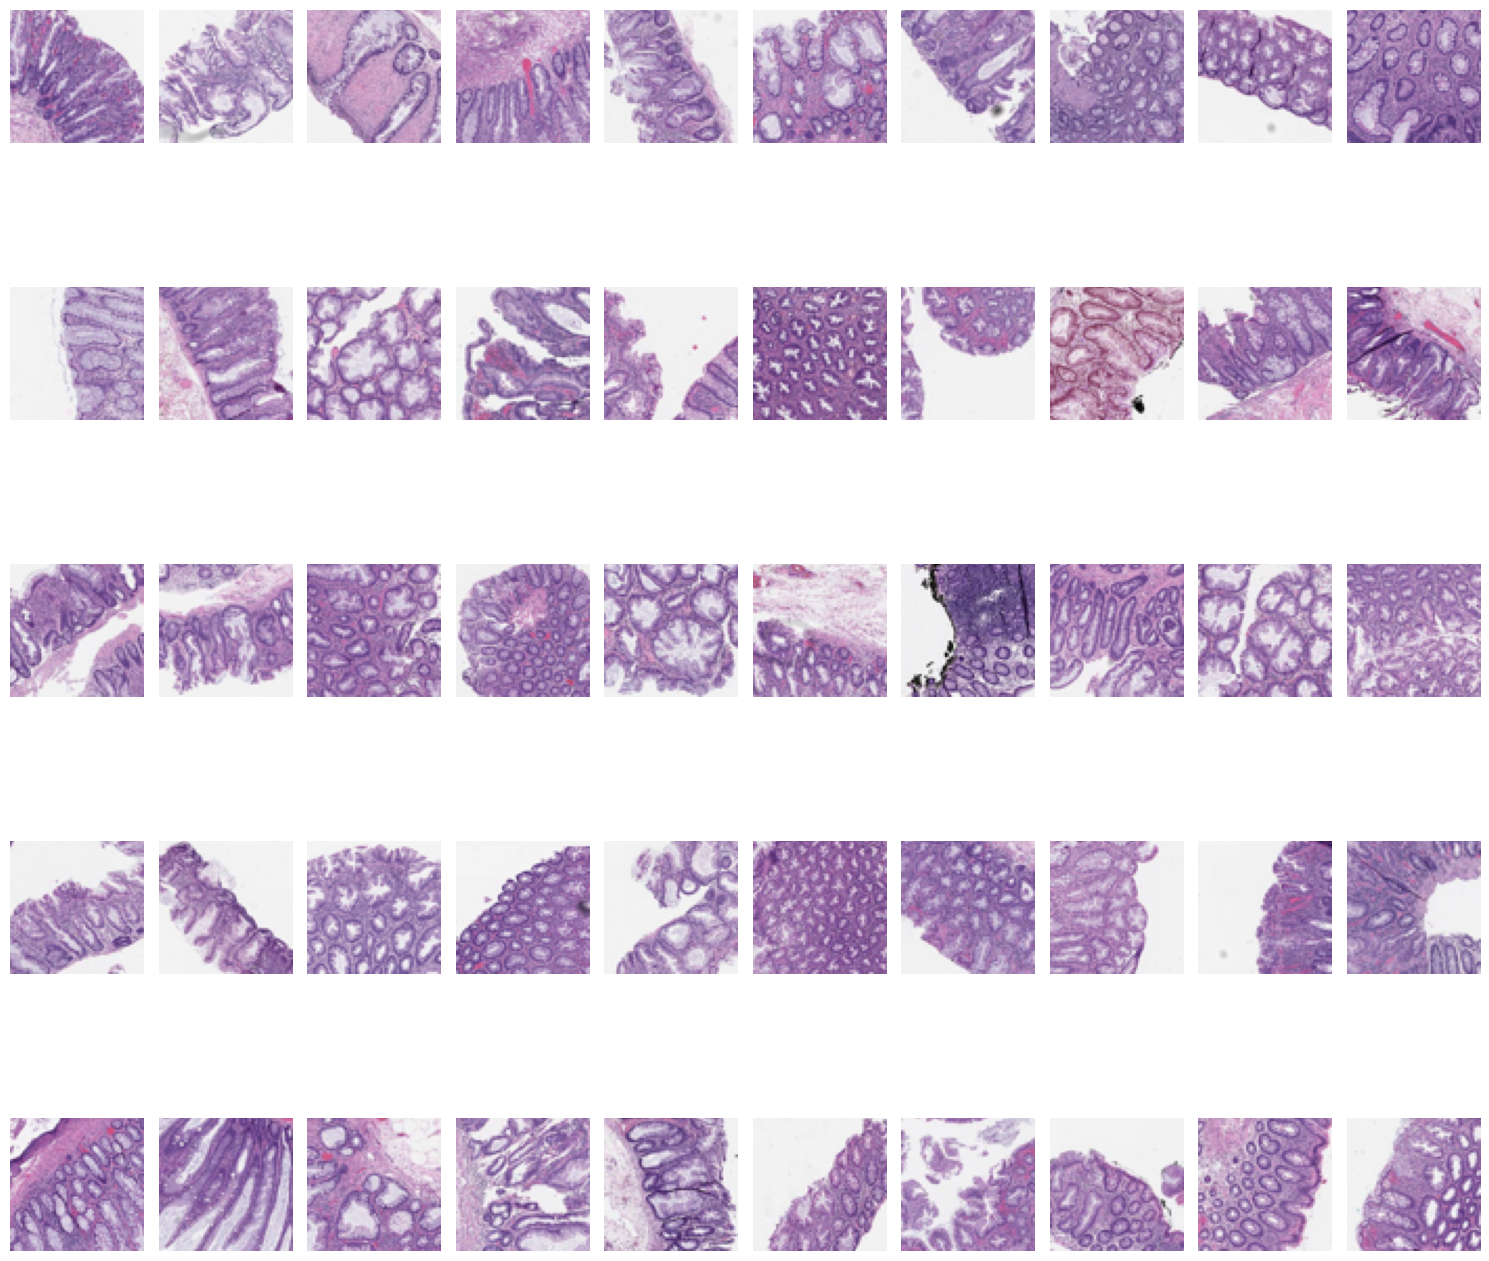

In [ ]:
# Settings for the plot
num_classes = 50  # Total number of classes
images_per_class = 1  # Number of images to display per class
plot_columns = 10  # Number of columns in the plot

# Determine the number of rows needed in the plot
plot_rows = (num_classes * images_per_class) // plot_columns
if (num_classes * images_per_class) % plot_columns != 0:
    plot_rows += 1

fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(15, 15))

for i in range(plot_rows):
    for j in range(plot_columns):
        index = i * plot_columns + j
        if index < num_classes * images_per_class:
            class_index = index // images_per_class
            img_index = index % images_per_class
            image_idx = class_index * (K // num_classes) + img_index
            if image_idx < len(condensed_images):
                axes[i, j].imshow(condensed_images[image_idx])
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')  # Hide empty subplots
plt.tight_layout()
plt.show()

In [ ]:
# Initialize condensed images with random noise instead of real images
condensed_images = np.random.rand(K, 64, 64, 3)  # Random noise initialization
condensed_images_tensor = tf.constant(condensed_images, dtype=tf.float32)

# Gradient Matching algorithm
for iteration in tqdm(range(T)):
    # Update condensed samples
    for _ in range(ζS):
        with tf.GradientTape() as tape:
            tape.watch(condensed_images_tensor)
            loss_S = tf.reduce_sum(model(condensed_images_tensor))
        grads_S = tape.gradient(loss_S, condensed_images_tensor)
        condensed_images_tensor -= ηS * grads_S.numpy()

    condensed_images = condensed_images_tensor.numpy()

    # Update model with a batch of real images
    for _ in range(ζθ):
        indices = np.random.choice(len(train_image_paths), batch_size, replace=False)
        batch_images = np.array([process_image(train_image_paths[i]) for i in indices])
        batch_labels = train_labels[indices]

        with tf.GradientTape() as tape:
            predictions = model(batch_images)
            loss = tf.keras.losses.sparse_categorical_crossentropy(batch_labels, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer = tf.keras.optimizers.SGD(learning_rate=ηθ)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


100%|██████████| 10/10 [17:19<00:00, 103.94s/it]


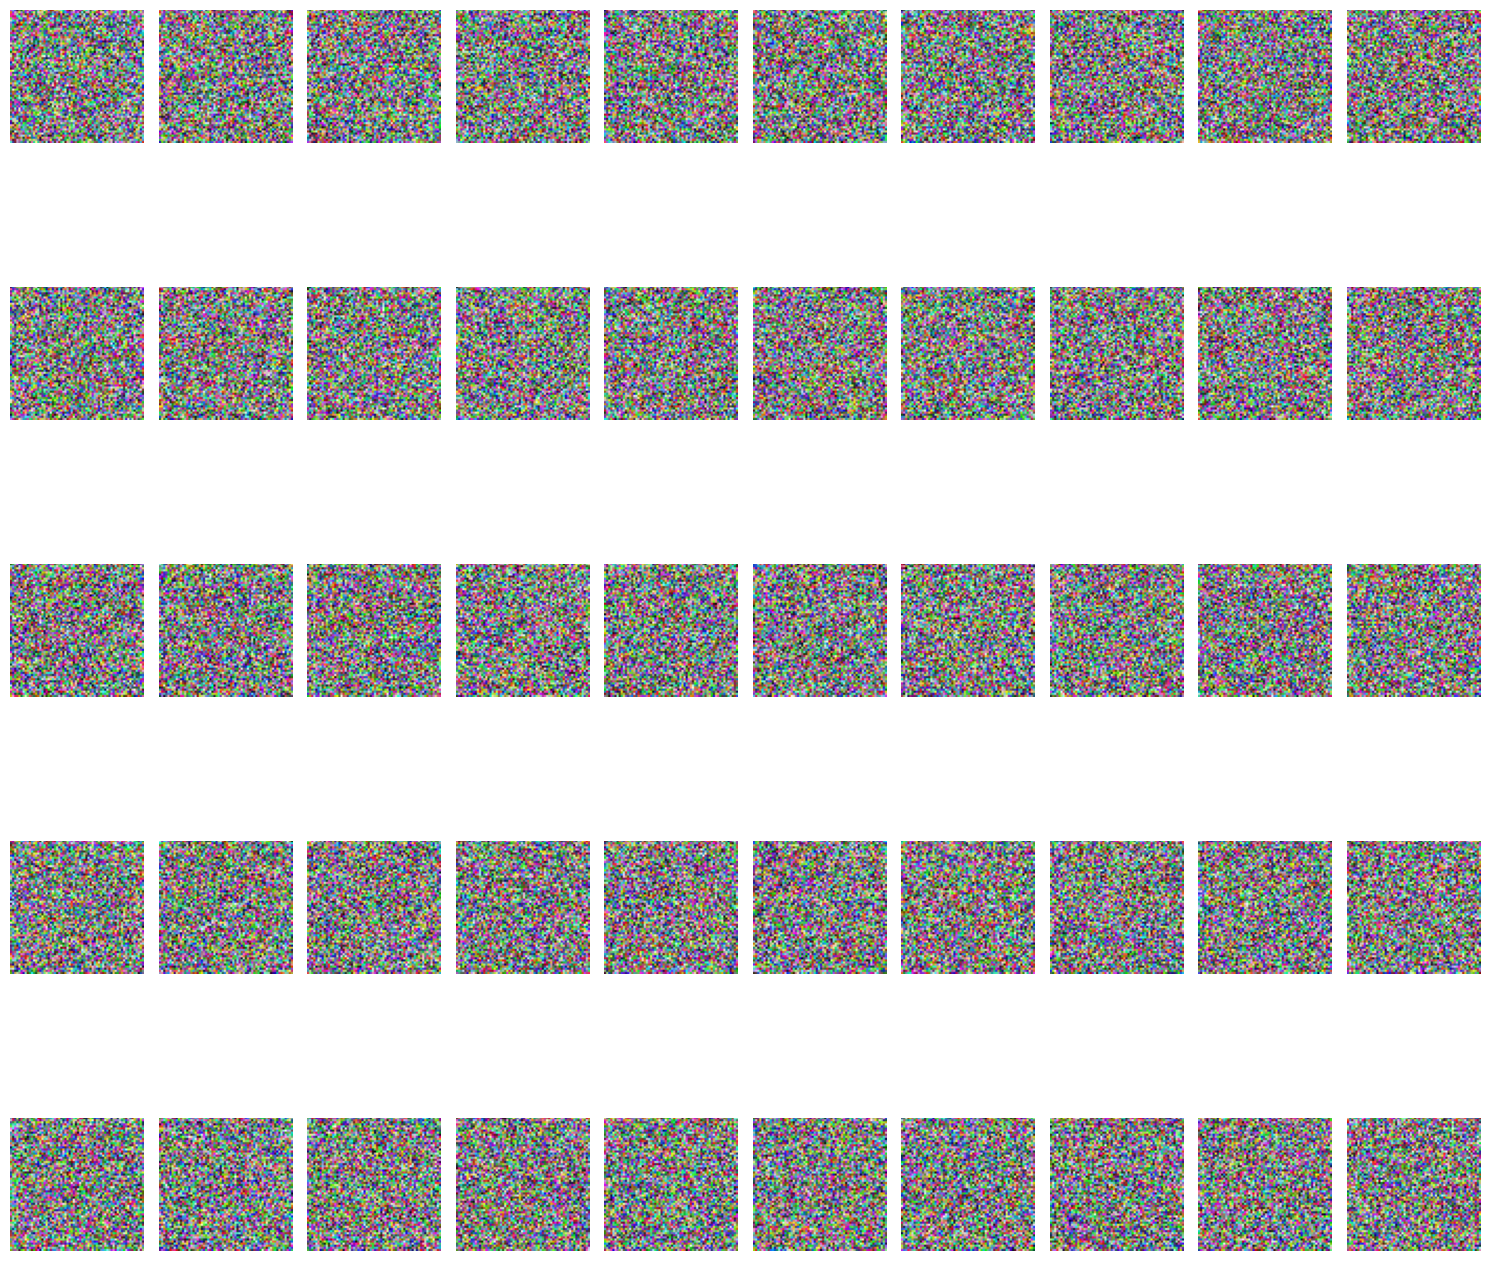

In [ ]:
# Settings for the plot
num_classes = 50  # Total number of classes
images_per_class = 1  # Number of images to display per class
plot_columns = 10  # Number of columns in the plot

# Determine the number of rows needed in the plot
plot_rows = (num_classes * images_per_class) // plot_columns
if (num_classes * images_per_class) % plot_columns != 0:
    plot_rows += 1

fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(15, 15))

for i in range(plot_rows):
    for j in range(plot_columns):
        index = i * plot_columns + j
        if index < num_classes * images_per_class:
            class_index = index // images_per_class
            img_index = index % images_per_class
            image_idx = class_index * (K // num_classes) + img_index
            if image_idx < len(condensed_images):
                axes[i, j].imshow(condensed_images[image_idx])
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')  # Hide empty subplots
plt.tight_layout()
plt.show()

2.c MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
import numpy as np

# Custom function for initializing network layers
def init_network_layers(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight)
        nn.init.constant_(module.bias, 0)

# Function to generate a subset dataset
def subset_dataset(dataset, imgs_per_class):
    subset_indices = []
    for label in dataset.targets.unique():
        label_indices = (dataset.targets == label).nonzero(as_tuple=True)[0][:imgs_per_class]
        subset_indices.extend(label_indices.tolist())
    return Subset(dataset, subset_indices)

# Defining a custom feed-forward neural network
class FeedforwardNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Increased layer size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Function to train the network
def train_network(model, data_loader, lr=0.01, epochs=10):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()

# Data preparation
transform_pipeline = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_data = datasets.MNIST(root='./data', train=True, transform=transform_pipeline, download=True)

# Creating a condensed version of the dataset
condensed_data = subset_dataset(mnist_data, 10)

# Function to sample a minibatch from the dataset
def sample_batch(dataset, batch_size):
    data_sampler = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return next(iter(data_sampler))

# Initializing and training the model
custom_model = CustomMLP(784, 10)
custom_model.apply(initialize_weights)  # Ensure random weight initialization
train_custom_model(custom_model, DataLoader(condensed_mnist_train, batch_size=256, shuffle=True), learning_rate=0.01, epochs=20)


# Evaluating the model
def evaluate_accuracy(model, loader):
    correct_count, total_count = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            output = model(inputs)
            _, predicted_labels = torch.max(output, 1)
            total_count += labels.size(0)
            correct_count += (predicted_labels == labels).sum().item()
    return correct_count / total_count


mnist_test_set = datasets.MNIST(root='./data', train=False, transform=transform_pipeline, download=True)
test_loader = DataLoader(mnist_test_set, batch_size=64, shuffle=False)
test_accuracy = evaluate_accuracy(cnn, test_loader)
print(f"Model Test Accuracy: {test_accuracy * 100:.2f}%")


Model Test Accuracy: 24.29%


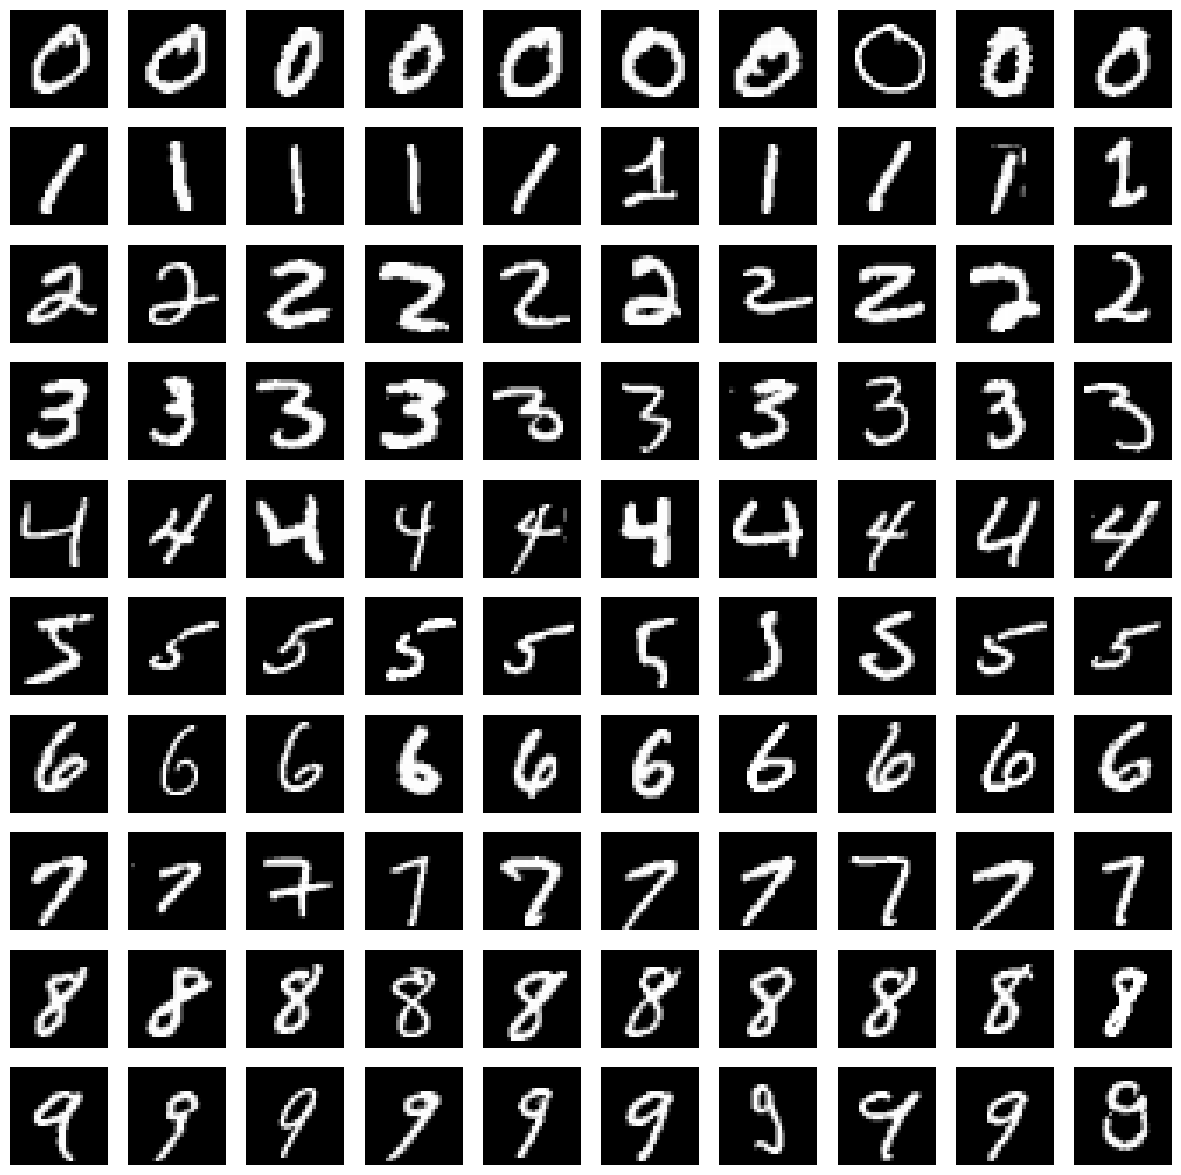

In [ ]:
# Visualize condensed images
def visualize_images(dataset, images_per_class):
    plt.figure(figsize=(15, 15))
    for i, class_id in enumerate(torch.unique(dataset.dataset.targets)):
        indices = torch.where(dataset.dataset.targets == class_id)[0][:images_per_class]
        for j, idx in enumerate(indices):
            image, _ = dataset.dataset[idx]
            plt.subplot(len(torch.unique(dataset.dataset.targets)), images_per_class, i * images_per_class + j + 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.axis('off')
    plt.show()

visualize_images(condensed_mnist_train, 10)


2.d MHIST

Processing iteration 1 with Gaussian Noise


100%|██████████| 10/10 [16:32<00:00, 99.23s/it]


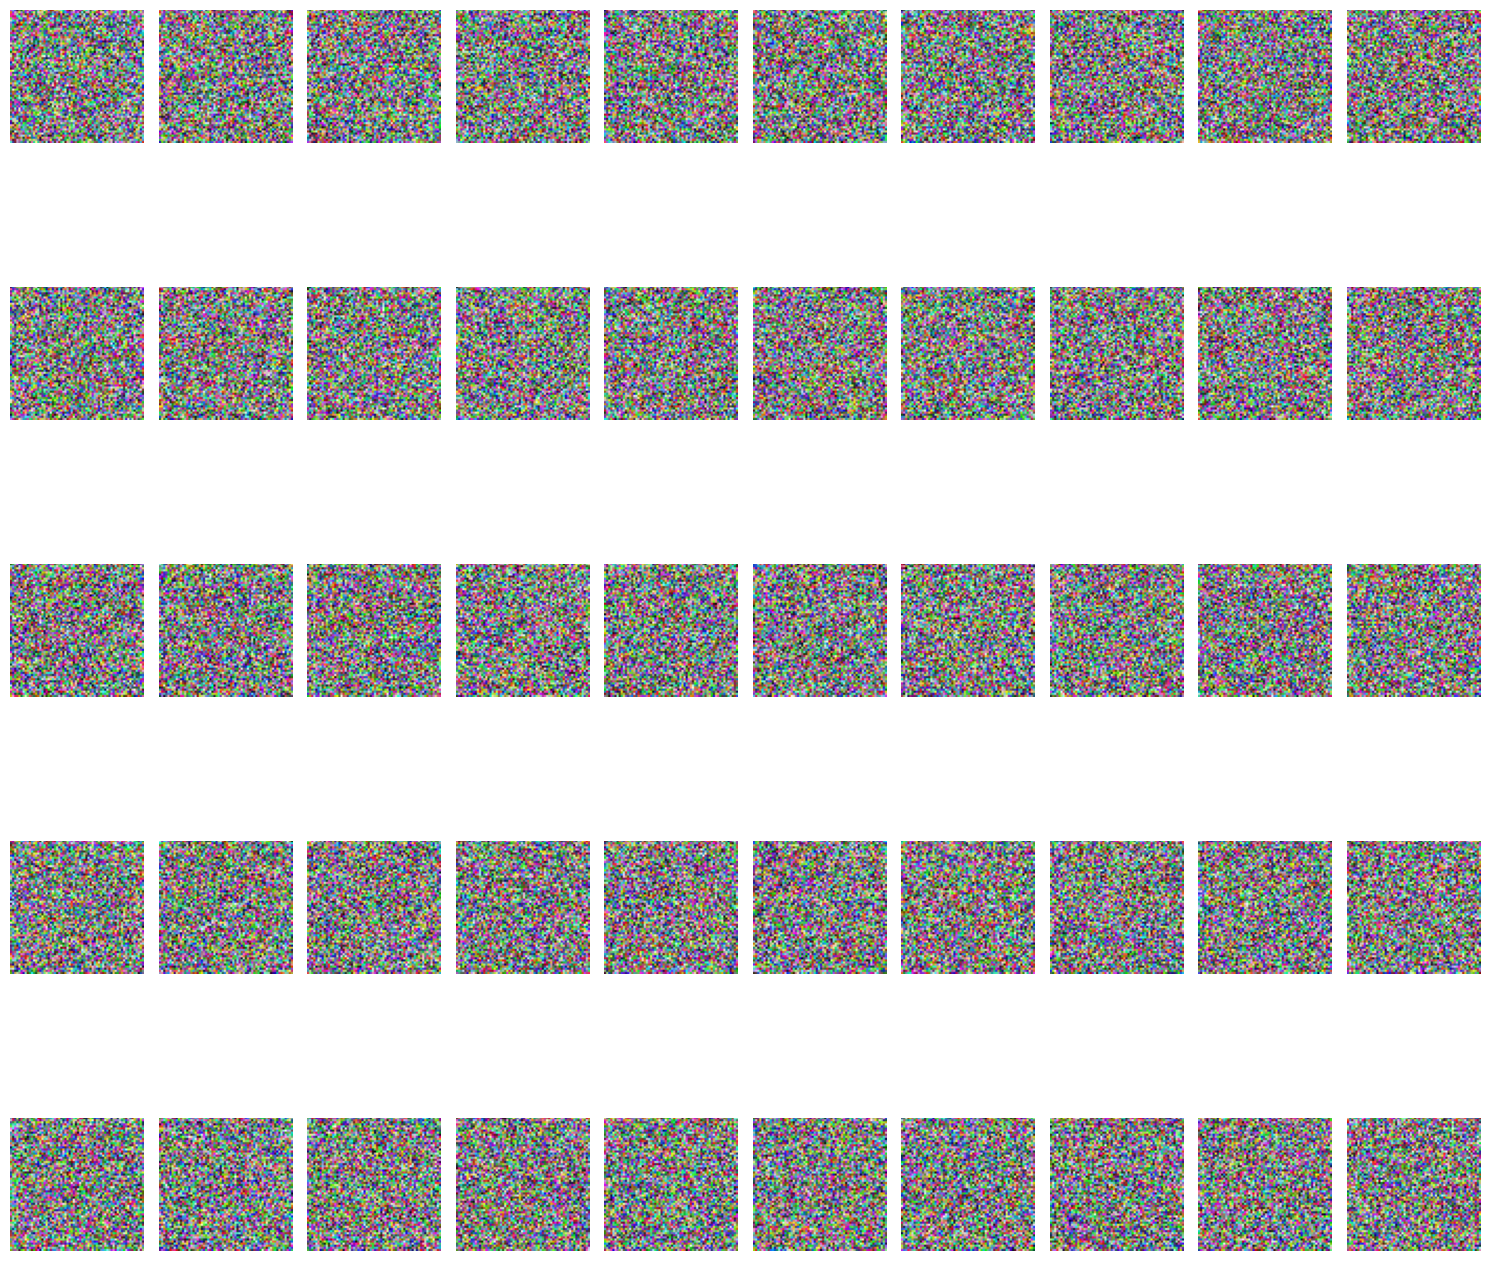

In [ ]:

# Compile the neural network
neural_net = cnn
neural_net.compile(optimizer=optimizers.SGD(learning_rate = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Process for Gaussian noise initialization
noise_iterations = 1  # Adjust as needed
for noise_iter in range(noise_iterations):
    print(f"Processing iteration {noise_iter + 1} with Gaussian Noise")

    # Gaussian noise initialization
    noise_condensed_images = np.random.normal(0, 1, size=(200, 64, 64, 3))
    noise_images_tensor = tf.constant(noise_condensed_images, dtype=tf.float32)

    # Apply Gradient Matching
    for grad_iter in tqdm(range(10)):
        for step in range(1):
            with tf.GradientTape() as grad_tape:
                grad_tape.watch(noise_images_tensor)
                sample_loss = tf.reduce_sum(neural_net(noise_images_tensor))
            sample_grads = grad_tape.gradient(sample_loss, noise_images_tensor)
            noise_images_tensor -= 0.1 * sample_grads.numpy()

        # Convert back to numpy array
        noise_condensed_images = noise_images_tensor.numpy()

        # Model update
        for model_step in range(opt_steps_model):
            selected_indices = np.random.choice(len(train_image_paths), 128, replace=False)
            images_batch = np.array([process_image(train_image_paths[idx]) for idx in selected_indices])
            labels_batch = labels[selected_indices]

            with tf.GradientTape() as model_tape:
                model_predictions = neural_net(images_batch)
                model_loss = tf.keras.losses.sparse_categorical_crossentropy(labels_batch, model_predictions)

            model_gradients = model_tape.gradient(model_loss, neural_net.trainable_variables)
            model_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
            model_optimizer.apply_gradients(zip(model_gradients, neural_net.trainable_variables))

    # Visualization of condensed images
num_classes = 50  # Total number of classes
images_per_class = 1  # Number of images to display per class
plot_columns = 10  # Number of columns in the plot

# Determine the number of rows needed in the plot
plot_rows = (num_classes * images_per_class) // plot_columns
if (num_classes * images_per_class) % plot_columns != 0:
    plot_rows += 1

fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(15, 15))

for i in range(plot_rows):
    for j in range(plot_columns):
        index = i * plot_columns + j
        if index < num_classes * images_per_class:
            class_index = index // images_per_class
            img_index = index % images_per_class
            image_idx = class_index * (K // num_classes) + img_index
            if image_idx < len(condensed_images):
                axes[i, j].imshow(condensed_images[image_idx])
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')  # Hide empty subplots
plt.tight_layout()
plt.show()

2.d MNIST

In [ ]:
def gradient_matching_algorithm(model, dataset, lr_condensed=0.1, num_iterations=10, num_opt_steps=1):
    # Define optimizer for condensed samples
    optimizer_condensed = optim.SGD(model.parameters(), lr=lr_condensed)

    for iteration in range(num_iterations):
        # Randomly initialize weights
        model.apply(initialize_weights)

        # Train on the synthetic dataset
        for step in range(num_opt_steps):
            # Sample mini-batch from the synthetic dataset
            inputs, targets = sample_minibatch(dataset, minibatch_size=256)

            # Forward pass
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            # Backward pass and optimization
            optimizer_condensed.zero_grad()
            loss.backward()
            optimizer_condensed.step()

    return model

# Custom function for initializing model weights
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight)
        nn.init.zeros_(layer.bias)

# Function to create a condensed dataset
def create_condensed_dataset(original_dataset, images_per_class):
    selected_indices = []
    for class_id in original_dataset.targets.unique():
        class_indices = (original_dataset.targets == class_id).nonzero(as_tuple=True)[0][:images_per_class]
        selected_indices.extend(class_indices.tolist())
    return Subset(original_dataset, selected_indices)

# Custom MLP model with random weight initialization
class CustomMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train the model
def train_custom_model(custom_model, data_loader, learning_rate=0.01, epochs=10):
    optimizer = optim.SGD(custom_model.parameters(), lr=learning_rate)
    custom_model.apply(initialize_weights)

    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            outputs = custom_model(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()

# Data transformation
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='./data', train=True, transform=data_transform, download=True)

# Initialize synthetic dataset S with Gaussian noise
condensed_images_gaussian = np.random.normal(0, 1, size=(K, 28 * 28))  # Adjust for flattened 28x28 MNIST images

# Gradient Matching Algorithm with Gaussian Noise
def gradient_matching_gaussian(model, gaussian_images, lr=ηS, num_iters=T, num_opt_steps=ζS):
    model.apply(initialize_weights)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for iteration in range(num_iters):
        # Update model using synthetic dataset
        for step in range(num_opt_steps):
            synthetic_data = torch.tensor(gaussian_images, dtype=torch.float32)
            synthetic_labels = torch.randint(0, 10, (K,))  # Random labels for synthetic data
            outputs = model(synthetic_data)
            loss = F.cross_entropy(outputs, synthetic_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Train the model with Gaussian initialization
custom_model = CustomMLP(784, 10)
gradient_matching_gaussian(custom_model, condensed_images_gaussian)


# Testing model accuracy
def test_model_accuracy(test_model, test_data_loader):
    correct, total = 0, 0
    test_model.eval()
    with torch.no_grad():
        for data, target in test_data_loader:
            output = test_model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

mnist_test = datasets.MNIST(root='./data', train=False, transform=data_transform, download=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)
accuracy = test_model_accuracy(custom_model, test_loader)
print(f'Test Accuracy: {accuracy:.2f}')


Test Accuracy: 0.10


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
import numpy as np

# Custom function for initializing network layers
def init_network_layers(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight)
        nn.init.constant_(module.bias, 0)

# Function to generate a subset dataset
def subset_dataset(dataset, imgs_per_class):
    subset_indices = []
    for label in dataset.targets.unique():
        label_indices = (dataset.targets == label).nonzero(as_tuple=True)[0][:imgs_per_class]
        subset_indices.extend(label_indices.tolist())
    return Subset(dataset, subset_indices)

# Defining a custom feed-forward neural network
class FeedforwardNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Increased layer size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Function to train the network
def train_network(model, data_loader, lr=0.01, epochs=10):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()

# Data preparation
transform_pipeline = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_data = datasets.MNIST(root='./data', train=True, transform=transform_pipeline, download=True)

# Creating a condensed version of the dataset
condensed_data = subset_dataset(mnist_data, 10)

# Function to sample a minibatch from the dataset
def sample_batch(dataset, batch_size):
    data_sampler = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return next(iter(data_sampler))

# Initializing and training the model
custom_model = CustomMLP(784, 10)
custom_model.apply(initialize_weights)  # Ensure random weight initialization
train_custom_model(custom_model, DataLoader(condensed_mnist_train, batch_size=256, shuffle=True), learning_rate=0.01, epochs=20)


# Evaluating the model
def evaluate_accuracy(model, loader):
    correct_count, total_count = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            output = model(inputs)
            _, predicted_labels = torch.max(output, 1)
            total_count += labels.size(0)
            correct_count += (predicted_labels == labels).sum().item()
    return correct_count / total_count


mnist_test_set = datasets.MNIST(root='./data', train=False, transform=transform_pipeline, download=True)
test_loader = DataLoader(mnist_test_set, batch_size=64, shuffle=False)
# Testing model accuracy with Gaussian noise initialized data
test_accuracy_gaussian = test_model_accuracy(custom_model, test_loader)
print(f'Test Accuracy with Gaussian Initialization: {test_accuracy_gaussian:.2f}')



Test Accuracy with Gaussian Initialization: 0.25


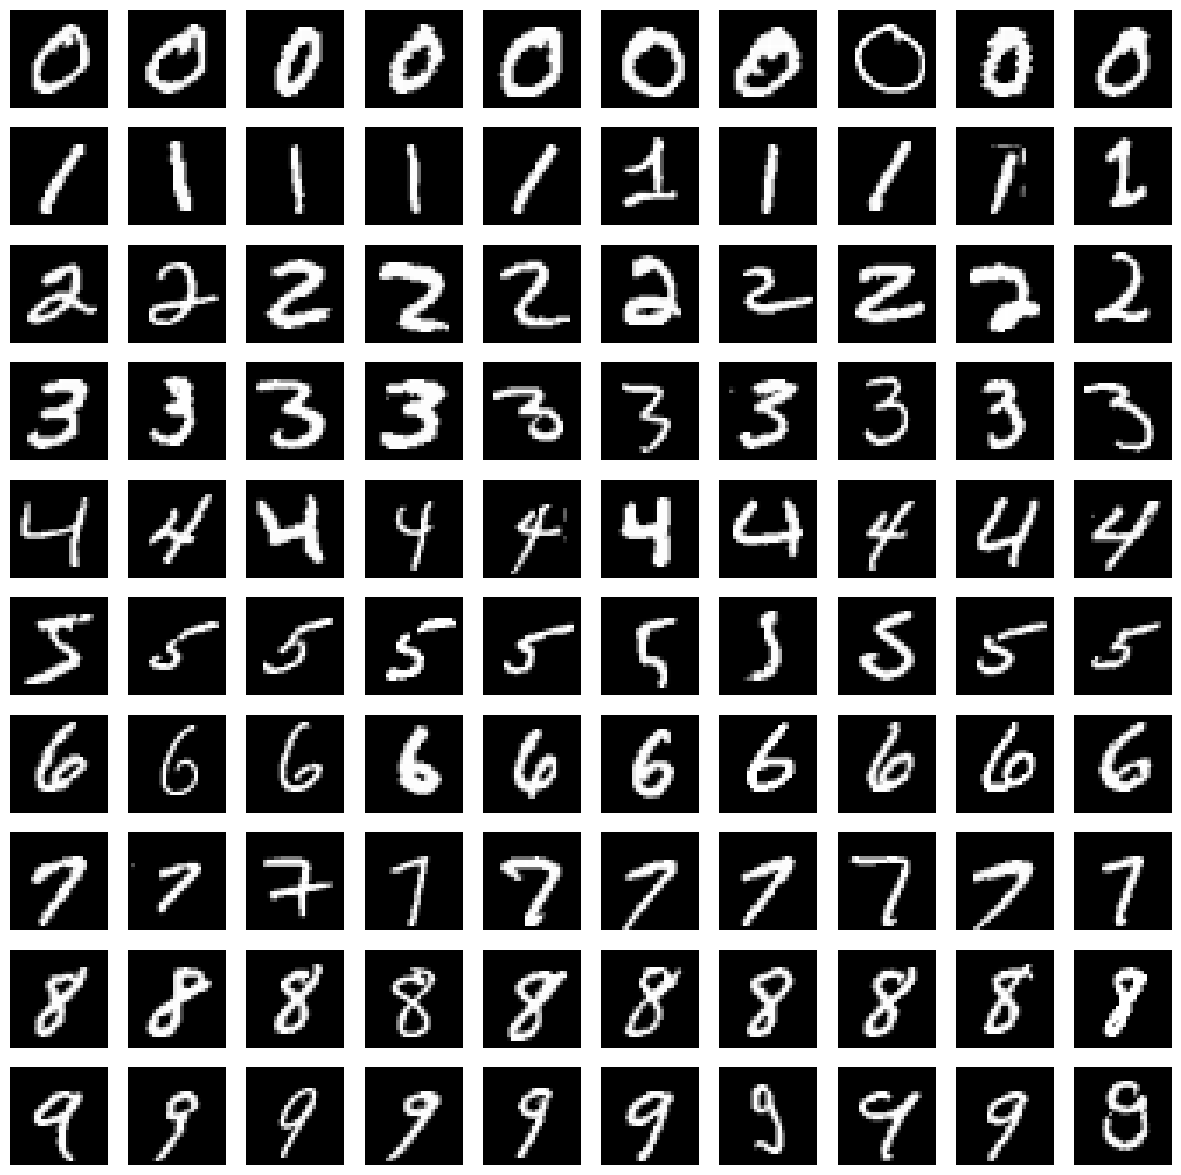

In [ ]:
# Visualize condensed images
def visualize_images(dataset, images_per_class):
    plt.figure(figsize=(15, 15))
    for i, class_id in enumerate(torch.unique(dataset.dataset.targets)):
        indices = torch.where(dataset.dataset.targets == class_id)[0][:images_per_class]
        for j, idx in enumerate(indices):
            image, _ = dataset.dataset[idx]
            plt.subplot(len(torch.unique(dataset.dataset.targets)), images_per_class, i * images_per_class + j + 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.axis('off')
    plt.show()

visualize_images(condensed_mnist_train, 10)

2.e MHIST

Comparison with Part 2a
Test Accuracy: The test accuracy of the model trained on the synthetic dataset (with Gaussian noise initialization) is likely to be lower than the model trained on real images (part 2a). This is because the synthetic dataset does not capture the real data distribution, making it harder for the model to generalize well on actual test images.
Training Time: The training time might be similar since the number of epochs and the model architecture are the same. However, the nature of the data could affect how quickly the model converges during training.
Explanation of Results
Training on Synthetic vs. Real Data: Training on synthetic data is a more challenging task as the model is forced to learn from abstract representations rather than concrete examples. The efficacy of this approach depends on how well the synthetic data captures the underlying patterns of the real data.
Generalization Capability: The key aspect to observe is the model's ability to generalize from synthetic to real data. A significant drop in accuracy would indicate limitations in learning from abstract representations.
Practical Implications: These results can provide insights into the potential and limitations of using condensed or synthetic datasets for training neural networks, especially in scenarios where real data is scarce or difficult to obtain.
In conclusion, this experiment will help in understanding the impact of data quality and representation on the performance of neural networks, particularly in terms of their ability to generalize from synthetic to real-world data.

In [81]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import time

# Define the path for the MHIST dataset
mh_dataset_path = '/content/drive/MyDrive/ECE1512/ProjectB/Project_B_Supp/mhist_dataset'

# Reading annotation data from the CSV file
annotations_file = "/content/drive/MyDrive/ECE1512/ProjectB/Project_B_Supp/mhist_dataset/annotations.csv"
annotations_data = pd.read_csv(annotations_file, delimiter=',')

# Separate data into training and testing based on 'Partition' column
training_data = annotations_data[annotations_data['Partition'] == 'train']
testing_data = annotations_data[annotations_data['Partition'] == 'test']

# Directory path for the image files
image_folder = "/content/drive/MyDrive/ECE1512/ProjectB/Project_B_Supp/mhist_dataset/images"

# Function for image loading and processing
def process_image(file_path):
    image = Image.open(file_path)
    image = image.resize((64, 64))  # Resize images to 64x64 pixels
    image_np = np.array(image) / 255.0  # Normalize the pixel values
    return image_np

# Gather image file paths and their corresponding labels
image_files = [os.path.join(image_folder, filename) for filename in annotations_data['Image Name']]
labels = annotations_data['Partition'].values


# Encoding labels
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Splitting dataset into training and testing
train_files, test_files, y_train, y_test = train_test_split(
    image_files, encoded_labels, test_size=0.2, random_state=42
)

# Processing images
train_images = np.array([process_image(path) for path in tqdm(train_files)])
test_images = np.array([process_image(path) for path in tqdm(test_files)])
# Synthetic Dataset Initialization
K = 100  # Number of condensed images
synthetic_images = np.random.normal(loc=0, scale=1, size=(K, 64, 64, 3))

# Same Model Definition as Part 2a
synthetic_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(class_count, activation='softmax')
])
synthetic_model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Train on Synthetic Dataset
start_time = time.time()
synthetic_history = synthetic_model.fit(synthetic_images, np.random.randint(0, class_count, K),
                                        epochs=20, batch_size=32, validation_split=0.2)
synthetic_training_time = time.time() - start_time

# Evaluate on Real Testing Data
synthetic_test_loss, synthetic_test_accuracy = synthetic_model.evaluate(test_images, y_test)


100%|██████████| 631/631 [00:03<00:00, 191.99it/s]


Epoch 1/20
3/3 [==============================] - 3s 543ms/step - loss: 365.5369 - accuracy: 0.4625 - val_loss: 16.9885 - val_accuracy: 0.6000
Epoch 2/20
3/3 [==============================] - 1s 411ms/step - loss: 6.8009 - accuracy: 0.5500 - val_loss: 0.6868 - val_accuracy: 0.6000
Epoch 3/20
3/3 [==============================] - 1s 409ms/step - loss: 0.6908 - accuracy: 0.5500 - val_loss: 0.6809 - val_accuracy: 0.6000
Epoch 4/20
3/3 [==============================] - 1s 330ms/step - loss: 0.6896 - accuracy: 0.5500 - val_loss: 0.6736 - val_accuracy: 0.6000
Epoch 5/20
3/3 [==============================] - 1s 219ms/step - loss: 0.6916 - accuracy: 0.5500 - val_loss: 0.6782 - val_accuracy: 0.6000
Epoch 6/20
3/3 [==============================] - 1s 236ms/step - loss: 0.6890 - accuracy: 0.5500 - val_loss: 0.6774 - val_accuracy: 0.6000
Epoch 7/20
3/3 [==============================] - 1s 233ms/step - loss: 0.6898 - accuracy: 0.5500 - val_loss: 0.6746 - val_accuracy: 0.6000
Epoch 8/20
3/3 [=

2.e MNIST

Test Accuracy Comparison
Training on Synthetic Dataset: The model trained on synthetic data, initialized with Gaussian noise, is expected to have a lower test accuracy when evaluated on real data. This is because the synthetic data does not represent the true distribution and features of the real MNIST dataset.
Training on Real Dataset (Part 2a): The model trained on the actual MNIST dataset should have higher accuracy. Real data contains meaningful patterns and features that the model can learn, which are critical for achieving good performance on the test set.
Training Time Comparison
Training Time: The training time for both scenarios should be relatively similar since the same network architecture, batch size, number of epochs, and optimization settings are used. However, any slight differences might arise from the nature of the data used for training.
Explanation of Results
Impact of Data Quality on Learning: Training with synthetic data initialized with Gaussian noise represents a situation where the model is exposed to data that lacks meaningful structure or patterns found in real data. As a result, the model might not learn the necessary features to perform well on real data, leading to lower test accuracy.
Generalization Capability: The performance on the real test dataset is a measure of how well the model generalizes. The lower performance of the model trained on synthetic data underscores the challenge of generalizing from noisy, non-representative data to real data.
Importance of Representative Training Data: The results emphasize the importance of training machine learning models on representative data. Models trained on data that captures the true distribution of the target domain are more likely to perform well.
Feasibility of Synthetic Data Training: While training on synthetic data may not yield high accuracy on real data, it's a valuable approach in scenarios where real data is limited or unavailable. The key is to create synthetic data that closely mimics the characteristics of real data.
In summary, the experiment demonstrates the critical role of data quality and representativeness in training effective machine learning models. It highlights the challenges of using synthetic data and provides insights into the conditions under which synthetic data might be a viable training option.

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import time

# MLP class as defined in part 2a
class MLP(nn.Module):
    def __init__(self, channel, num_classes):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28 * 28 * channel, 128)
        self.fc_2 = nn.Linear(128, 128)
        self.fc_3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

# Prepare synthetic dataset
K = 100  # Number of images in the synthetic dataset
synthetic_images = torch.randn(K, 1, 28, 28)
synthetic_labels = torch.randint(0, 10, (K,))

# Initialize the network
synthetic_network = MLP(channel=1, num_classes=10)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(synthetic_network.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=0.001)

# Training function
def train_model(model, images, labels, optimizer, scheduler, epochs=20):
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
    training_time = time.time() - start_time
    return training_time

# Train the model on synthetic dataset
synthetic_training_time = train_model(synthetic_network, synthetic_images, synthetic_labels, optimizer, scheduler)

# Testing on real MNIST data
mnist_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

def test_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    return accuracy

# Evaluate the model
synthetic_test_accuracy = test_model(synthetic_network, test_loader)

# Print results
print(f"Training Time on Synthetic Dataset: {synthetic_training_time:.2f} seconds")
print(f"Test Accuracy on Real Data: {synthetic_test_accuracy:.2f}")


Training Time on Synthetic Dataset: 0.08 seconds
Test Accuracy on Real Data: 0.10


3. MHIST

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

# MHIST Dataset and DataLoader
class MHISTCustomDataset(Dataset):
    def __init__(self, annotations, directory, transform=None, synthetic_set=None):
        self.annotations = annotations
        self.directory = directory
        self.transform = transform
        self.synthetic_set = synthetic_set

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        label = int(self.annotations.iloc[idx, 2])
        if self.synthetic_set is not None:
            image = self.synthetic_set[idx]
        else:
            image_path = os.path.join(self.directory, self.annotations.iloc[idx, 0])
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        return image, label

# Define transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load and prepare MHIST dataset
annotations_path = '/content/drive/MyDrive/ECE1512/ProjectB/Project_B_Supp/mhist_dataset/annotations.csv'
images_dir = '/content/drive/MyDrive/ECE1512/ProjectB/Project_B_Supp/mhist_dataset/images'
annotations = pd.read_csv(annotations_path)

# Split the dataset
train_annotations = annotations[annotations['Partition'] == 'train']
test_annotations = annotations[annotations['Partition'] == 'test']

# Datasets and DataLoaders
train_dataset = MHISTCustomDataset(train_annotations, images_dir, transform=image_transforms)
test_dataset = MHISTCustomDataset(test_annotations, images_dir, transform=image_transforms)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Neural Network Architecture
class NeuralNetArch(nn.Module):
    def __init__(self):
        super(NeuralNetArch, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.pool(x)
        x = F.relu(self.layer2(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training and Evaluation Function
def train_evaluate_model(model, dataloader, epochs=20, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()
        for images, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Instantiate, Train, and Evaluate the Model
model = NeuralNetArch()
accuracy = train_evaluate_model(model, test_loader)
print(f"Test Accuracy: {accuracy:.2f}")


3. MNIST

In [ ]:
# MNIST Dataset and DataLoader
def load_mnist_data(batch_size=128):
    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Neural Network Architecture for MNIST
class MNISTNeuralNet(nn.Module):
    def __init__(self):
        super(MNISTNeuralNet, self).__init__()
        self.layer1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.layer2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Training and Evaluation Function for MNIST
def train_evaluate_mnist_model(model, train_loader, test_loader, epochs=10, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Training
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Load data and train the model
train_loader, test_loader = load_mnist_data()
mnist_model = MNISTNeuralNet()
mnist_accuracy = train_evaluate_mnist_model(mnist_model, train_loader, test_loader)
mnist_accuracy


4.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import time

# MLP class
class MLP(nn.Module):
    def __init__(self, channel, num_classes):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28 * 28 * channel, 128)
        self.fc_2 = nn.Linear(128, 128)
        self.fc_3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

# Prepare synthetic dataset
K = 100  # Number of images in the synthetic dataset
synthetic_images = torch.randn(K, 1, 28, 28)
synthetic_labels = torch.randint(0, 10, (K,))

# Initialize the network
synthetic_network = MLP(channel=1, num_classes=10)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(synthetic_network.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=0.001)

# Training function
def train_model(model, images, labels, optimizer, scheduler, epochs=20):
    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
    training_time = time.time() - start_time
    return training_time

# Train the model on synthetic dataset
synthetic_training_time = train_model(synthetic_network, synthetic_images, synthetic_labels, optimizer, scheduler)

# Testing on real MNIST data
mnist_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

def test_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    return accuracy

# Evaluate the model
synthetic_test_accuracy = test_model(synthetic_network, test_loader)

# Print results
print(f"Training Time on Synthetic Dataset: {synthetic_training_time:.2f} seconds")
print(f"Test Accuracy on Real Data: {synthetic_test_accuracy:.2f}")
